In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms
from torchvision.models.detection.retinanet import RetinaNet
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetHead

from sklearn.metrics import roc_auc_score, mean_squared_error
from IPython.display import clear_output
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
%cd /content/drive/MyDrive/petfinder

/content/drive/MyDrive/petfinder


In [4]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
img_name = 'train/0007de18844b0dbbb5e1f607da0606e0.jpg'
image = Image.open(img_name).convert('RGB')

transform = transforms.ToTensor()
image = transform(image)

## "Utility" transforms 
applied to all images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


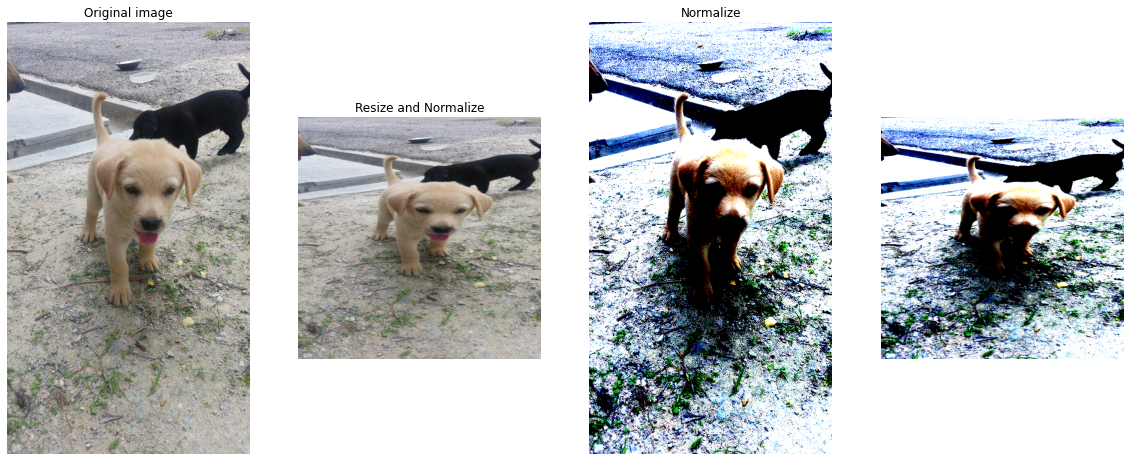

In [7]:
t1 = transforms.Resize((512, 512))
t2 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))

axes[0].imshow(image.permute(1,2,0))
axes[0].axis('off')
axes[0].set_title('Original image')

im = image.clone()
axes[1].imshow(t1(im).permute(1,2,0))
axes[1].axis('off')
axes[1].set_title('Resize')

im = image.clone()
axes[2].imshow(t2(im).permute(1,2,0))
axes[2].axis('off')
axes[2].set_title('Normalize')

im = image.clone()
axes[3].imshow(t2(t1(im)).permute(1,2,0))
axes[3].axis('off')
axes[1].set_title('Resize and Normalize')

plt.show()

## "Good" transforms
that shouldn't change Pawpularity score in our opinion

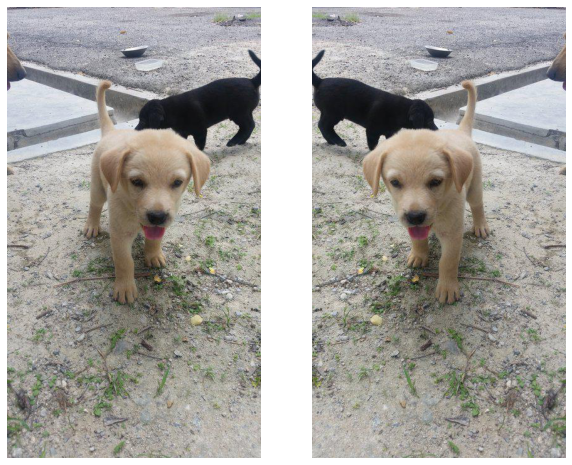

In [8]:
t1 = transforms.RandomHorizontalFlip(p=1)
n = 2
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(10, 10))

for i in range(n):
    im = image.clone()
    if i != 0:
        im = t1(im)
    axes[i].imshow(im.permute(1,2,0))
    axes[i].axis('off')
plt.show()

## "Bad" transforms
that can change Pawpularity score in our opinion

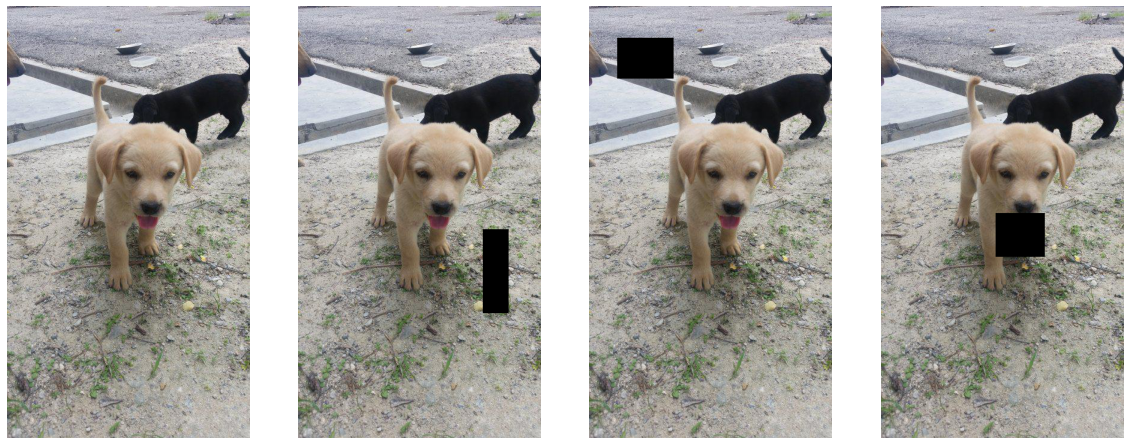

In [9]:
t1 = transforms.RandomErasing(p=1, scale=(0.02, 0.03), ratio=(0.3, 3.3))
n = 4
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 20))

for i in range(n):
    im = image.clone()
    if i != 0:
        im = t1(im)
    axes[i].imshow(im.permute(1,2,0))
    axes[i].axis('off')
plt.show()

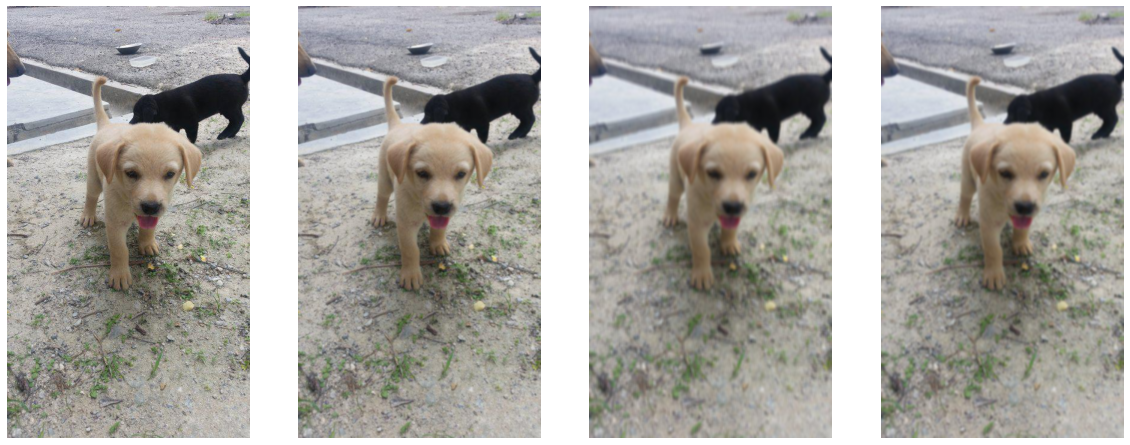

In [10]:
t1 = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
n = 4
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 20))

for i in range(n):
    im = image.clone()
    if i != 0:
        im = t1(im)
    axes[i].imshow(im.permute(1,2,0))
    axes[i].axis('off')
plt.show()

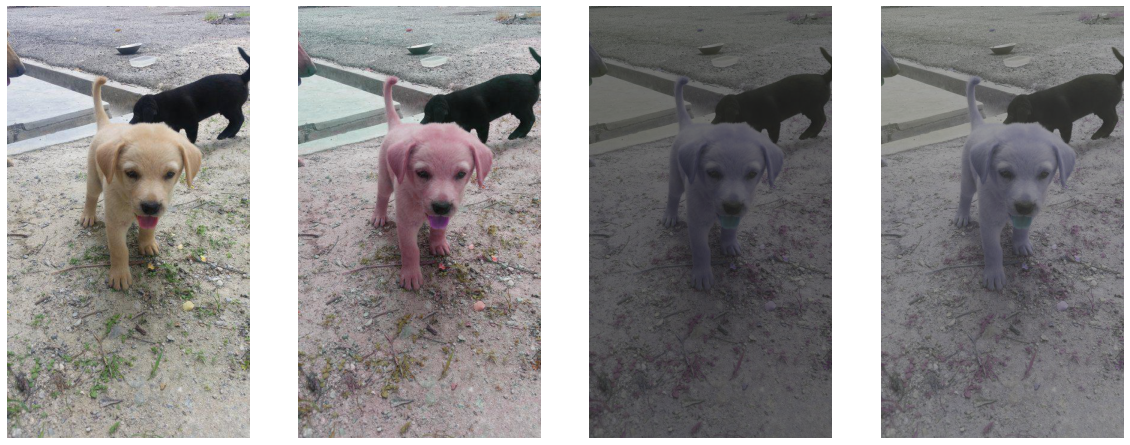

In [11]:
t1 = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
n = 4
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 20))

for i in range(n):
    im = image.clone()
    if i != 0:
        im = t1(im)
    axes[i].imshow(im.permute(1,2,0))
    axes[i].axis('off')
plt.show()

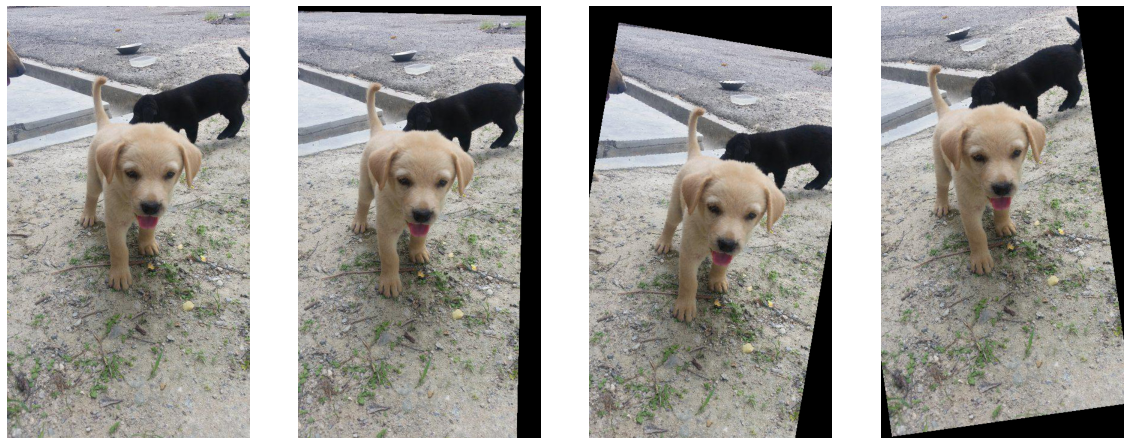

In [12]:
t1 = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1))
n = 4
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 20))

for i in range(n):
    im = image.clone()
    if i != 0:
        im = t1(im)
    axes[i].imshow(im.permute(1,2,0))
    axes[i].axis('off')
plt.show()

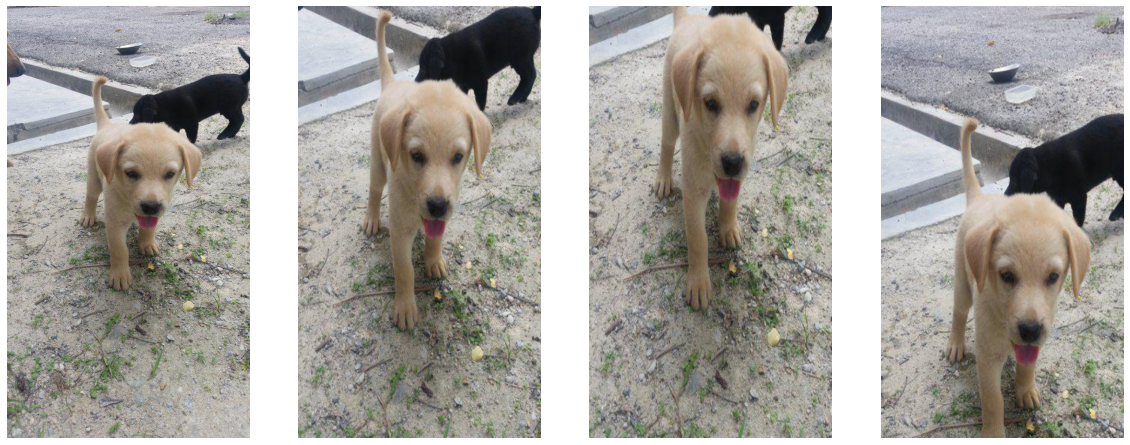

In [13]:
t1 = transforms.RandomResizedCrop((image.shape[1], image.shape[2]), scale=(0.5, 1.0))
n = 4
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 20))

for i in range(n):
    im = image.clone()
    if i != 0:
        im = t1(im)
    axes[i].imshow(im.permute(1,2,0))
    axes[i].axis('off')
plt.show()

## Our function for transforms

In [14]:
def get_transform(train, target_size, norm=True):
    transform = []
    transform.append(transforms.ToTensor())
    transform.append(transforms.Resize(target_size))
    
    # if norm part needed for image display in usual colors
    if norm:
        transform.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        
    if train:
        transform.append(transforms.RandomHorizontalFlip(p=0.5))
    return transforms.Compose(transform)